# Kaggle House Price Challenge (Ames, Iowa) : 
<p><a name="sections"></a></p>

## Sections

- <a href="#trees">Decision Trees</a><br>
 - <a href="#trees_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#trees_cvgrid">CV Grid Search</a><br>
 - <a href="#trees_bestmodel">Create Trees Best Model</a><br>
 - <a href="#trees_plot">Plot: Variable Importance</a><br>
- <a href="#forest">Random Forests</a><br>
 - <a href="#forest_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#forest_cvgrid">CV Grid Search</a><br>
 - <a href="#forest_bestmodel">Create Random Forest Best Model</a><br>
- <a href="#gboost">Gradient Boosting</a><br>
 - <a href="#gboost_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#gboost_cvgrid">CV Grid Search</a><br>
 - <a href="#gboost_bestmodel">Create Gradient Boost Best Model</a><br>
- <a href="#kaggle">Kaggle Submissions</a><br>
 - <a href="#kaggle_trees">Best Predictions : Decision Trees</a><br>
 - <a href="#kaggle_forest">Best Predictions : Random Forests</a><br>
 - <a href="#kaggle_gboost">Best Predictions : Gradient Boosting</a><br>
 - <a href="#kaggle_result">Kaggle Results : Root-Mean-Square-Log-Error</a><br>

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 100)

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [3]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [4]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [5]:
Y_TRAIN= train_df['SalePrice']
X_TRAIN = train_df.drop('SalePrice', axis=1)
X_TEST = test_df.copy()

In [6]:
#del train_df, test_df
print(X_TRAIN.shape)
print(X_TEST.shape)

(1460, 79)
(1459, 79)


In [7]:
Y_TRAIN=np.log(Y_TRAIN)
#print(Y_TRAIN)

In [8]:
all_data = pd.concat([X_TRAIN, X_TEST])
all_data.shape

(2919, 79)

#### Find all Categorical Data

In [9]:
cats = []
for col in all_data.columns.values:
    if all_data[col].dtype == 'object':
        cats.append(col)

#### Create Separate Continuous Data

In [10]:
df_cont = all_data.drop(cats, axis=1)
df_cat = all_data[cats]

### Handle Missing Data for continuous data
- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
- Remove outliers using Median Absolute Deviation
- Calculate skewness for each variable and if greater than 0.75 transform it
- Apply the sklearn.Normalizer to each column

In [11]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subs


#### Handle Missing Data for Categorical Data

- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
- Apply the sklearn.LabelEncoder
- For each categorical variable determine the number of unique values and for each, create a new column that is binary



In [12]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [13]:
df_cont.shape

(2919, 34)

In [14]:
df_cat.shape

(2919, 171)

In [15]:
all_data=pd.concat([df_cont, df_cat], axis = 1)
X_TRAIN = all_data.iloc[0:1460,]
X_TEST = all_data.iloc[1460:,]

In [16]:
print(X_TRAIN.shape)
print(Y_TRAIN.shape)
print(X_TEST.shape)

(1460, 205)
(1460,)
(1459, 205)


In [17]:
#Write Processed Data to File
X_TRAIN.to_csv('X_TRAIN.csv')
Y_TRAIN.to_csv('Y_TRAIN.csv')
X_TEST.to_csv('X_TEST.csv')

### Create Test/Train Split

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size = .25, random_state=5)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1095, 205)
(1095,)
(365, 205)
(365,)


In [19]:
tree_model = tree.DecisionTreeRegressor(min_samples_leaf=10,max_depth=9)
tree_model.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [20]:
#tree_model.feature_importances_

In [22]:
def calc_rmsle (tree_model, x_input, y_input):
    msle=np.mean(( y_input-tree_model.predict(x_input))** 2)
    return(math.sqrt(msle))

In [23]:
calc_rmsle(tree_model,x_test,y_test)

0.1910042700884719

<p><a name="trees"></a></p>
## Decision Trees

### Depth of Tree

In [24]:
depth = range(1, 18)
depth_train_error = []
depth_test_error = []
tree_model = tree.DecisionTreeRegressor()
for i in depth:
    tree_model.set_params(max_depth=i, min_samples_leaf=1)
    tree_model.fit(x_train, y_train)
    depth_train_error.append(calc_rmsle(tree_model,x_train,y_train))
    depth_test_error.append(calc_rmsle(tree_model,x_test,y_test))

### Minimum Number of Samples per Leaf

In [25]:
leaf = range(1, 30)
leaf_train_error = []
leaf_test_error = []
tree_model = tree.DecisionTreeRegressor()
for i in leaf:
    tree_model.set_params( min_samples_leaf=i)
    tree_model.fit(x_train, y_train)
    leaf_train_error.append(calc_rmsle(tree_model,x_train,y_train))
    leaf_test_error.append(calc_rmsle(tree_model,x_test,y_test))

<p><a name="trees_plot"></a></p>
### Plots : Sweep Tree Depth & Minimum Sample per Leaf 

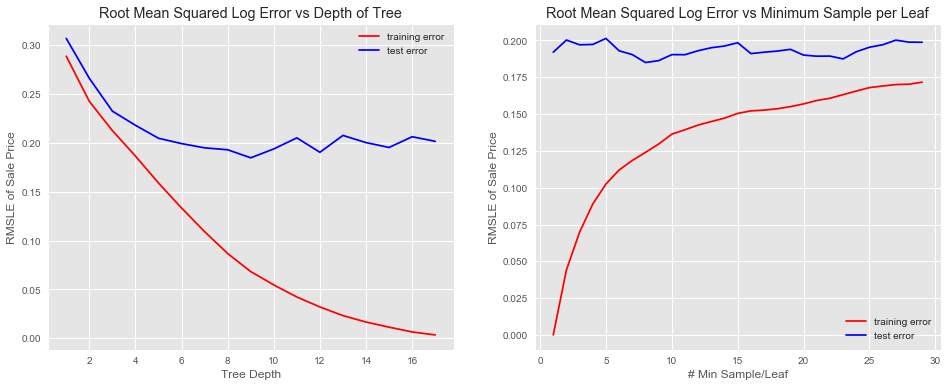

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
#plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
#plt.fig
plt.plot(depth, depth_train_error, c='red', label='training error')
plt.plot(depth, depth_test_error, c='blue', label='test error')
plt.legend()
plt.ylabel('RMSLE of Sale Price')
plt.xlabel('Tree Depth')
plt.title('Root Mean Squared Log Error vs Depth of Tree')

plt.subplot(1, 2, 2)
plt.plot(leaf, leaf_train_error, c='red', label='training error')
plt.plot(leaf, leaf_test_error, c='blue', label='test error')
plt.legend()
plt.ylabel('RMSLE of Sale Price')
plt.xlabel('# Min Sample/Leaf')
plt.title('Root Mean Squared Log Error vs Minimum Sample per Leaf')
plt.show()

<p><a name="trees_cvgrid"></a></p>
### CV Grid Search for Decision Tree

In [28]:
from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ["mse"],
    "max_depth": range(1, 30),
    "min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=0)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5,scoring='neg_mean_squared_error', n_jobs=-1)
%time grid_search_tree.fit(x_train, y_train)

Wall time: 22.2 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=29, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': range(1, 30), 'criterion': ['mse'], 'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [90]:
## best parameters
print(grid_search_tree.best_params_)
rmsle_grid_tree_train=calc_rmsle(grid_search_tree,x_train,y_train)
rmsle_grid_tree_test=calc_rmsle(grid_search_tree,x_test,y_test)
print(rmsle_grid_tree_train)
print(rmsle_grid_tree_test)

{'max_depth': 9, 'min_samples_leaf': 10, 'criterion': 'mse'}
0.1374470662167449
0.19100427008847184


<p><a name="trees_bestmodel"></a></p>
## Create Best Tree Model
- Pass Best Parameters to Best Model
- Train Best Model with FULL Train Set

In [54]:
best_tree_model=tree.DecisionTreeRegressor(**grid_search_tree.best_params_)
best_tree_model.fit(X=X_TRAIN,y=Y_TRAIN)
calc_rmsle(best_tree_model,x_test,y_test)

0.12963576756256764

In [37]:
type(X_TRAIN)

pandas.core.frame.DataFrame

In [55]:
best_tree_model.predict(x_test)
rmsle_best_tree_train=calc_rmsle(best_tree_model,x_train,y_train)
rmsle_best_tree_test=calc_rmsle(best_tree_model,x_test,y_test)
print(rmsle_best_tree_train)
print(rmsle_best_tree_test)

0.13422326226750209
0.12963576756256764


<p><a name="trees_plot2"></a></p>
### Plot: Feature Importance

In [169]:
feature_importance = list(zip(x_train.columns, best_tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')
#[::-1]
#feature_sort

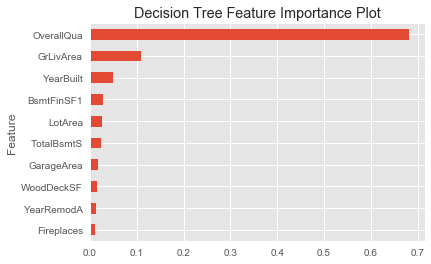

In [258]:
feature_name=[i.decode("utf-8") for (i, j) in feature_sort if j>0.01]
feature_val=[j for (i, j) in feature_sort if j>0.01]
#feature_sort.
fimp_df=pd.DataFrame({'Feature':feature_name,'Importance':feature_val}).reset_index(drop=True)
#fimp_df.plot.barh(x='Feature',y='Importance')
fimp_df.plot(kind='barh',x='Feature',y='Importance',
             legend=None, title='Decision Tree Feature Importance Plot')

<p><a name="forest"></a></p>
## Random Forest

In [62]:
rf_model = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [63]:
rf_model.fit(x_train, y_train)
msle=np.mean(( y_test-rf_model.predict(x_test))** 2)
math.sqrt(msle)

0.13491867043506386

In [64]:
rf_model = RandomForestRegressor(min_samples_leaf=10,max_depth=9,n_jobs=-1)
ntrees_range = range(20, 500, 25)  # OOB score will warning if too few trees
ntrees_train_error = []
ntrees_test_error = []
oob_error = []

for ntrees in ntrees_range:
    rf_model.set_params(n_estimators=ntrees, random_state=0,  oob_score=True)
    rf_model.fit(x_train, y_train)
    ntrees_train_error.append(calc_rmsle(rf_model,x_train,y_train))
    ntrees_test_error.append(calc_rmsle(rf_model,x_test,y_test))

<p><a name="forest_plot"></a></p>
### Plot: Sweep Hyperparameter Number of Trees

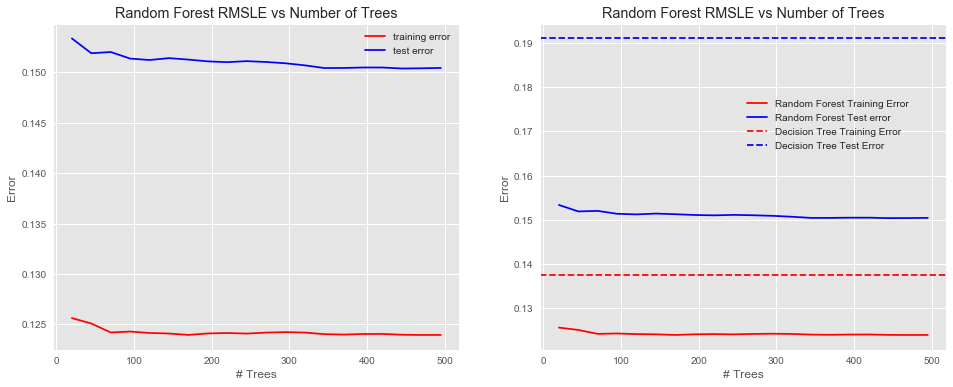

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ntrees_range, ntrees_train_error, c='red', label='training error')
plt.plot(ntrees_range, ntrees_test_error, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('# Trees')
plt.title('Random Forest RMSLE vs Number of Trees')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ntrees_range, ntrees_train_error, c='red', label='Random Forest Training Error')
plt.plot(ntrees_range, ntrees_test_error, c='blue', label='Random Forest Test error')
plt.axhline(y=rmsle_grid_tree_train,ls='--',c='red',label='Decision Tree Training Error')
plt.axhline(y=rmsle_grid_tree_test,ls='--',c='blue',label='Decision Tree Test Error')
rmsle_best_tree_train
plt.ylabel('Error')
plt.xlabel('# Trees')
plt.title('Random Forest RMSLE vs Number of Trees')

plt.legend(loc=(0.5,0.6))
plt.show()

<p><a name="forest_cvgrid"></a></p>
### CV Grid Search for Random Forest

In [144]:
grid_search_forest = RandomForestRegressor(n_jobs=-1)
grid_para_forest = [{
    "n_estimators": [50, 100,200,300,400,500],
    "criterion": ["mse"],
    "min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
    }]
grid_search_forest = GridSearchCV(grid_search_forest, grid_para_forest, 
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_forest.fit(x_train, y_train)

Wall time: 2min 33s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'n_estimators': [50, 100, 200, 300, 400, 500], 'criterion': ['mse']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [167]:
grid_search_forest.best_params_

{'criterion': 'mse', 'min_samples_leaf': 2, 'n_estimators': 300}

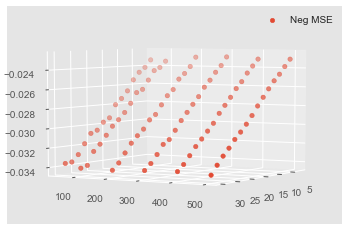

In [164]:
mtscore=grid_search_forest.cv_results_['mean_test_score'].data
minleaf=grid_search_forest.cv_results_['param_min_samples_leaf'].data
nestim=grid_search_forest.cv_results_['param_n_estimators'].data

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(minleaf.tolist(), nestim.tolist(), mtscore.tolist(), label="Neg MSE")
ax.legend()
ax.view_init(elev=5., azim=30)

<p><a name="forest_bestmodel"></a></p>
## Create Best Random Forest Model
- Pass Best Parameters to Best Model
- Train Best Model with FULL Train Set

In [168]:
## best parameters
print(grid_search_forest.best_params_)
rmsle_grid_forest_train=calc_rmsle(grid_search_forest,x_train,y_train)
rmsle_grid_forest_test=calc_rmsle(grid_search_forest,x_test,y_test)
print(rmsle_grid_forest_train)
print(rmsle_grid_forest_test)

{'n_estimators': 300, 'criterion': 'mse', 'min_samples_leaf': 2}
0.06770028175786777
0.13482390451700513


In [85]:
best_forest_model=RandomForestRegressor(**grid_search_forest.best_params_)
best_forest_model.fit(X=X_TRAIN,y=Y_TRAIN)


0.06667876830818344
0.057042971168235944


In [72]:
best_forest_model.predict(x_test)
rmsle_best_forest_train=calc_rmsle(best_forest_model,x_train,y_train)
rmsle_best_forest_test=calc_rmsle(best_forest_model,x_test,y_test)
print(rmsle_best_forest_train)
print(rmsle_best_forest_test)

0.06586781128226
0.055639872207961225


<p><a name="gboost"></a></p>
## Gradient Boosting

In [76]:
gboost_model = GradientBoostingRegressor()
learnrate_range = learnrate_range = [10**i for i in np.arange(-4.,0,.25)]
#print(learnrate_range)
gboost_train_error = []
gboost_test_error = []
oob_error = []

for learnrate in learnrate_range:
    gboost_model.set_params(learning_rate=learnrate, random_state=0,n_estimators=100)
    gboost_model.fit(x_train, y_train)
    gboost_train_error.append(calc_rmsle(gboost_model,x_train,y_train))
    gboost_test_error.append(calc_rmsle(gboost_model,x_test,y_test))

In [77]:
print(learnrate_range)

[0.0001, 0.00017782794100389227, 0.00031622776601683794, 0.0005623413251903491, 0.001, 0.0017782794100389228, 0.0031622776601683794, 0.005623413251903491, 0.01, 0.017782794100389229, 0.031622776601683791, 0.056234132519034911, 0.10000000000000001, 0.17782794100389229, 0.31622776601683794, 0.56234132519034907]


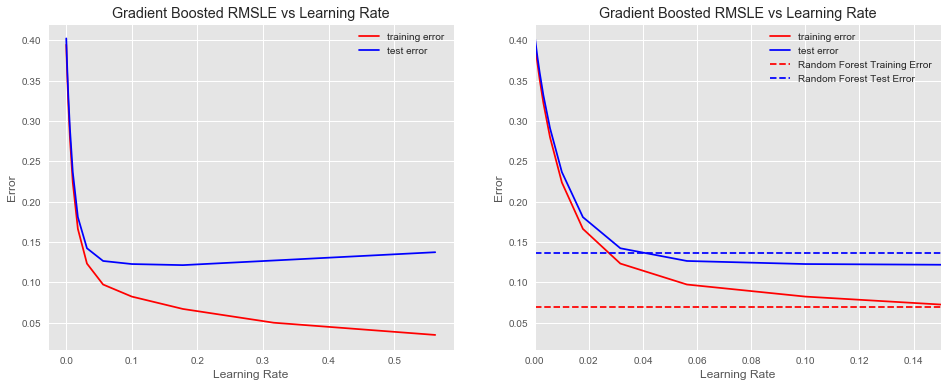

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(learnrate_range, gboost_train_error, c='red', label='training error')
plt.plot(learnrate_range, gboost_test_error, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('Learning Rate')
plt.title('Gradient Boosted RMSLE vs Learning Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(learnrate_range, gboost_train_error, c='red', label='training error')
plt.plot(learnrate_range, gboost_test_error, c='blue', label='test error')
plt.axhline(y=rmsle_grid_forest_train,ls='--',c='red',label='Random Forest Training Error')
plt.axhline(y=rmsle_grid_forest_test,ls='--',c='blue',label='Random Forest Test Error')
plt.ylabel('Error')
plt.xlabel('Learning Rate')
plt.title('Gradient Boosted RMSLE vs Learning Rate')
plt.xlim([0,0.15])
plt.legend()

<p><a name="gboost_cvgrid"></a></p>
### CV Grid Search for Gradient Boosting

In [79]:
grid_search_gboost = GradientBoostingRegressor()
grid_para_gboost = [{
    "learning_rate": [0.01,0.05,0.1,0.15,0.2,0.25],
    "n_estimators": [50, 100, 200, 300, 500]
    #"max_depth": range(1, 30),
    #"min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
    }]
grid_search_gboost = GridSearchCV(grid_search_gboost, grid_para_gboost, 
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_gboost.fit(x_train, y_train)

Wall time: 45.8 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 200, 300, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [80]:
print(grid_search_gboost.best_params_)
calc_rmsle(grid_search_gboost,x_test,y_test)

{'n_estimators': 300, 'learning_rate': 0.1}


0.1187872860884791

<p><a name="gboost_bestmodel"></a></p>
## Create Best Gradient Boost Model
- Pass Best Parameters to Best Model
- Train Best Model with FULL Train Set

In [82]:
best_gboost_model=GradientBoostingRegressor(**grid_search_gboost.best_params_)
best_gboost_model.fit(X=X_TRAIN,y=Y_TRAIN)
calc_rmsle(best_gboost_model,x_test,y_test)

0.0537864790306962

In [83]:
best_gboost_model.predict(x_test)
rmsle_best_gboost_train=calc_rmsle(best_gboost_model,x_train,y_train)
rmsle_best_gboost_test=calc_rmsle(best_gboost_model,x_test,y_test)
print(rmsle_best_gboost_train)
print(rmsle_best_gboost_test)

0.05776290287406608
0.0537864790306962


<p><a name="kaggle"></a></p>
## Kaggle Submission

<p><a name="kaggle_trees"></a></p>
### Best Model Decision Tree

In [92]:
trees_pred=np.exp(best_tree_model.predict(X_TEST))
kaggle_trees_df=pd.DataFrame({'Id':test_ID,'SalePrice':trees_pred})
kaggle_trees_df.to_csv('kaggle_trees_df.csv',index=None)
kaggle_trees_df.head()

,Id,SalePrice
0,1461,135264.931994
1,1462,165861.980272
2,1463,228387.748435
3,1464,183995.439200
4,1465,224868.383759


<p><a name="kaggle_forest"></a></p>
### Best Model Random Forest

In [93]:
forest_pred=np.exp(best_forest_model.predict(X_TEST))
kaggle_forest_df=pd.DataFrame({'Id':test_ID,'SalePrice':forest_pred})
kaggle_forest_df.to_csv('kaggle_forest_df.csv',index=None)
kaggle_forest_df.head()

,Id,SalePrice
0,1461,128614.962776
1,1462,153885.834053
2,1463,174743.371827
3,1464,182967.418636
4,1465,197189.930550


<p><a name="kaggle_gboost"></a></p>
### Best Model Gradient Boosting

In [94]:
gboost_pred=np.exp(best_gboost_model.predict(X_TEST))
kaggle_gboost_df=pd.DataFrame({'Id':test_ID,'SalePrice':gboost_pred})
kaggle_gboost_df.to_csv('kaggle_gboost_df.csv',index=None)
kaggle_gboost_df.head()


,Id,SalePrice
0,1461,124482.417301
1,1462,154833.780481
2,1463,184013.902377
3,1464,197970.976446
4,1465,191709.942546


<p><a name="kaggle_result"></a></p>
### Kaggle RMSLE

In [334]:
kaggle_trees_rmsle=0.18817
kaggle_forest_rmsle=0.14652
kaggle_gboost_rmsle=0.13338

<p><a name="predplot_trees"></a></p>
### Prediction Plots - Decision Trees

In [211]:
worst_tree_model = tree.DecisionTreeRegressor(min_samples_leaf=50,max_depth=3)
worst_tree_model.fit(X_TRAIN,Y_TRAIN)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [244]:
type(Y_TRAIN)
trees_price_df=pd.DataFrame({
    'Train_Price':np.exp(Y_TRAIN),
    'Worst_Tree_Price':np.exp(worst_tree_model.predict(X_TRAIN)),
    'Best_Tree_Price':np.exp(best_tree_model.predict(X_TRAIN))})
trees_price_df=trees_price_df.sort_values('Train_Price')
trees_price_df.head()

,Best_Tree_Price,Train_Price,Worst_Tree_Price
495,61084.675721,34900.0,99703.360278
916,61084.675721,35311.0,99703.360278
968,76425.073160,37900.0,99703.360278
533,61084.675721,39300.0,99703.360278
30,76425.073160,40000.0,99703.360278


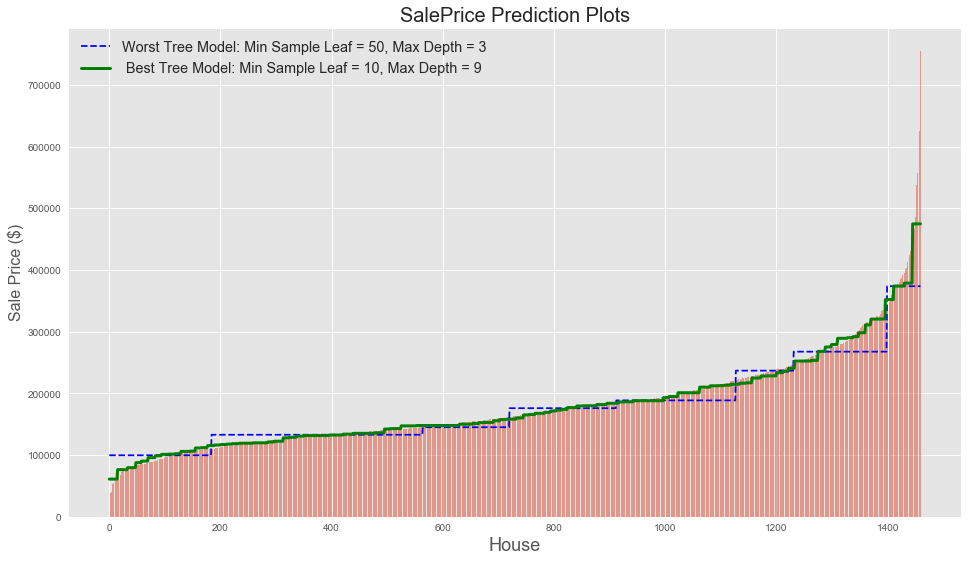

In [245]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('x-large')
plt.figure(figsize=(16, 9))
plt.bar(range(0,Y_TRAIN.shape[0]),np.exp(sorted(Y_TRAIN)),alpha=0.5)
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(worst_tree_model.predict(X_TRAIN))),color='b',
        linestyle='--', label='Worst Tree Model: Min Sample Leaf = 50, Max Depth = 3')
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(best_tree_model.predict(X_TRAIN))),color='g',
        linewidth=3, label=' Best Tree Model: Min Sample Leaf = 10, Max Depth = 9')
plt.legend(prop = fontP)
plt.title('SalePrice Prediction Plots',fontsize=20)
plt.xlabel('House', fontsize=18)
plt.ylabel('Sale Price ($)', fontsize=16)